In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
import numpy as np
import tensorflow as tf

import keras.backend as K
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

from spektral.layers import GraphConv, GlobalAvgPool, EdgeConditionedConv

from spektral.utils import Batch, batch_iterator
from spektral.utils import label_to_one_hot, normalized_laplacian
from spektral.layers.ops import sp_matrix_to_sp_tensor

import graph

/Users/zichen/venv37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zichen/venv37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zichen/venv37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zichen/venv37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
# set random seed
SEED = 2020
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_random_seed(SEED)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
import networkx as nx
import scipy.sparse as sp

In [4]:
from spektral.datasets import mnist

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Load data
X_train, y_train, X_val, y_val, X_test, y_test, _ = mnist.load_data()
X_train, X_val, X_test = X_train[..., None], X_val[..., None], X_test[..., None]
N = X_train.shape[-2]      # Number of nodes in the graphs
F = X_train.shape[-1]      # Node features dimensionality
n_out = 10  # Dimension of the target
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(50000, 784, 1) (50000,)
(10000, 784, 1) (10000,)
(10000, 784, 1) (10000,)


In [7]:
def grid_graph(m, k=8, corners=False):
    '''
    To create adjacency matrix as per Defferrard et al. 2016
    '''
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=k, metric='euclidean')
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, k*m**2//2))
    return A


def draw_graph(A, m=28, ax=None, spring_layout=False, size_factor=10):
    '''Draw the graph given adjacency matrix(A),
    optionally with spring_layout.
    '''
    assert m**2 == A.shape[0] == A.shape[1]
    # Create the nx.Graph object
    G = nx.from_scipy_sparse_matrix(A)
    print('Number of nodes: %d; Number of edges: %d' % \
          (G.number_of_nodes(), G.number_of_edges()))
    grid_coords = graph.grid(m)

    if spring_layout:
        # remove nodes without edges
        nodes_without_edges = [n for n, k in  G.degree() if k == 0]
        G.remove_nodes_from(nodes_without_edges)
        print('After removing nodes without edges:')
        print('Number of nodes: %d; Number of edges: %d' % \
              (G.number_of_nodes(), G.number_of_edges()))
    
    z = graph.grid(m)
    
    # initial positions
    pos = {n: z[n] for n in G.nodes()} 
    
    if spring_layout:
        pos = nx.spring_layout(G, 
                               pos=pos,
                               iterations=200)
    
    ax = nx.draw(G, pos,
                 node_size=[G.degree(n) * size_factor for n in G.nodes()],
                 ax=ax
                )
    return ax

3198 > 3136 edges


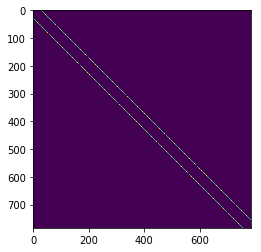

In [8]:
A = grid_graph(28, k=8)
plt.imshow(A.todense())

Number of nodes: 784; Number of edges: 3198


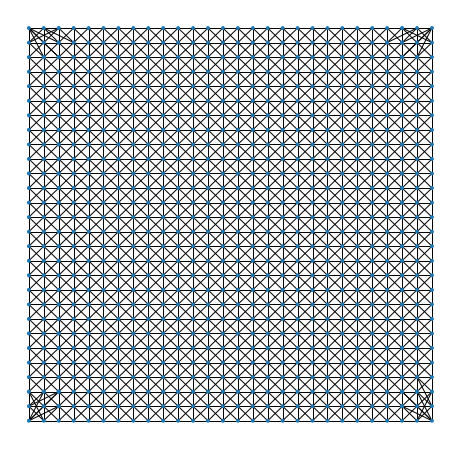

In [9]:
# visualize the graph
fig, ax = plt.subplots(figsize=(8, 8))
ax = draw_graph(A, ax=ax, size_factor=1)

Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


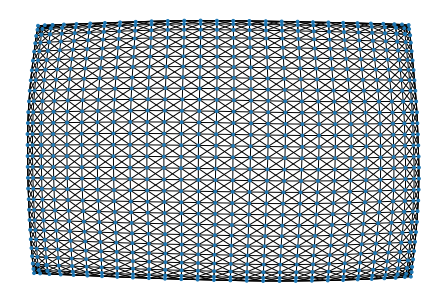

In [10]:
ax = draw_graph(A, ax=ax, size_factor=1, spring_layout=True)

# Feature graph as a 2D Euclidean grid in the entire space

Number of nodes: 784; Number of edges: 3198
Number of nodes: 784; Number of edges: 3198
After removing nodes without edges:
Number of nodes: 784; Number of edges: 3198


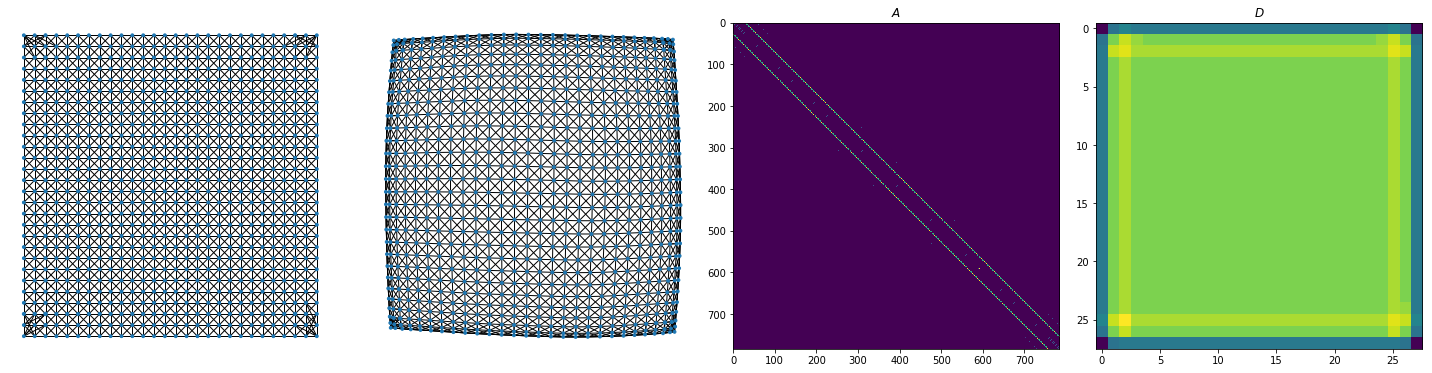

In [11]:
fig, axes = plt.subplots(figsize=(20, 5), ncols=4)

axes[2].imshow(A.todense())
axes[2].set_title('$A$')

# degree matrix D
D = A.sum(axis=0).reshape(28, 28)
axes[3].imshow(D)
axes[3].set_title('$D$')

axes[0] = draw_graph(A, ax=axes[0], size_factor=1)
axes[1] = draw_graph(A, ax=axes[1], size_factor=1, spring_layout=True)

fig.tight_layout()
fig.savefig('img/grid_graph.pdf')

# Feature graphs as a "pruned" grid for each digit

Number of nodes: 784; Number of edges: 1055
Number of nodes: 784; Number of edges: 1055
After removing nodes without edges:
Number of nodes: 344; Number of edges: 1055


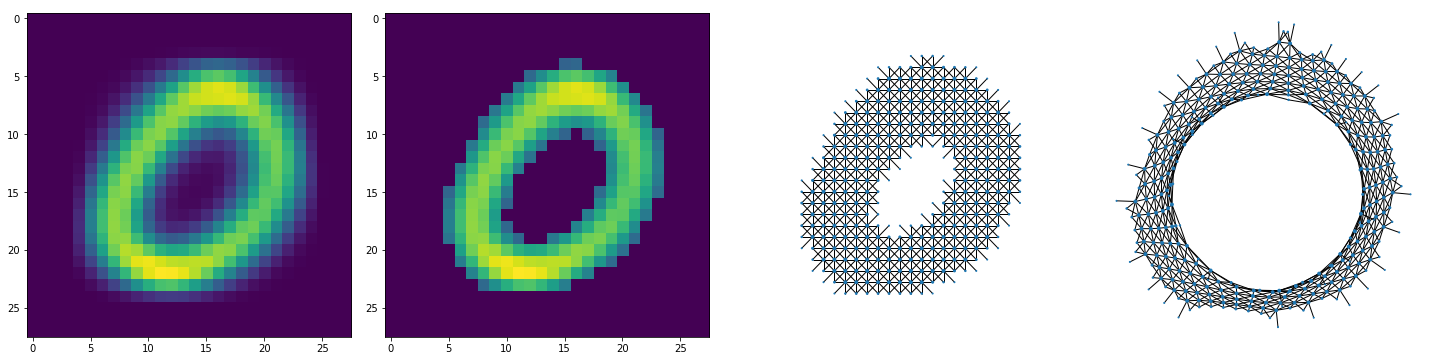

Number of nodes: 784; Number of edges: 462
Number of nodes: 784; Number of edges: 462
After removing nodes without edges:
Number of nodes: 157; Number of edges: 462


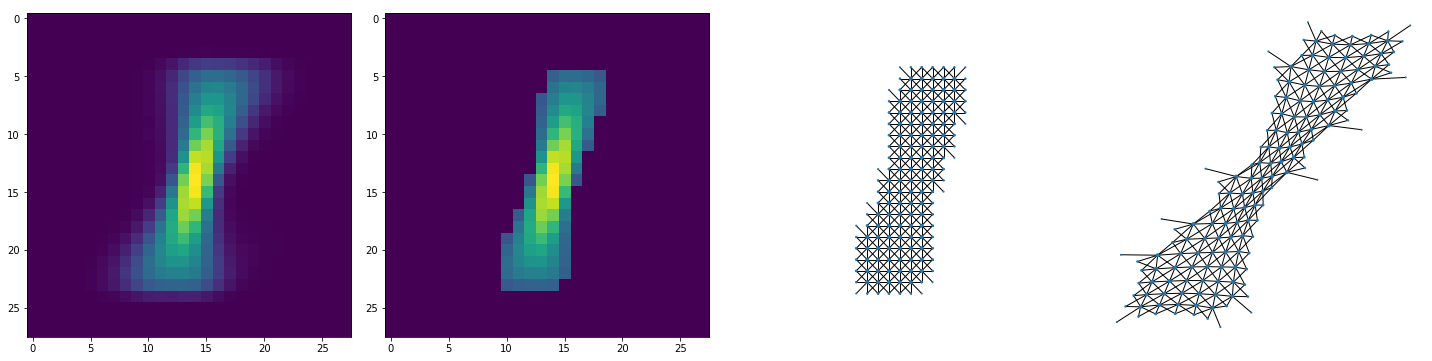

Number of nodes: 784; Number of edges: 920
Number of nodes: 784; Number of edges: 920
After removing nodes without edges:
Number of nodes: 295; Number of edges: 920


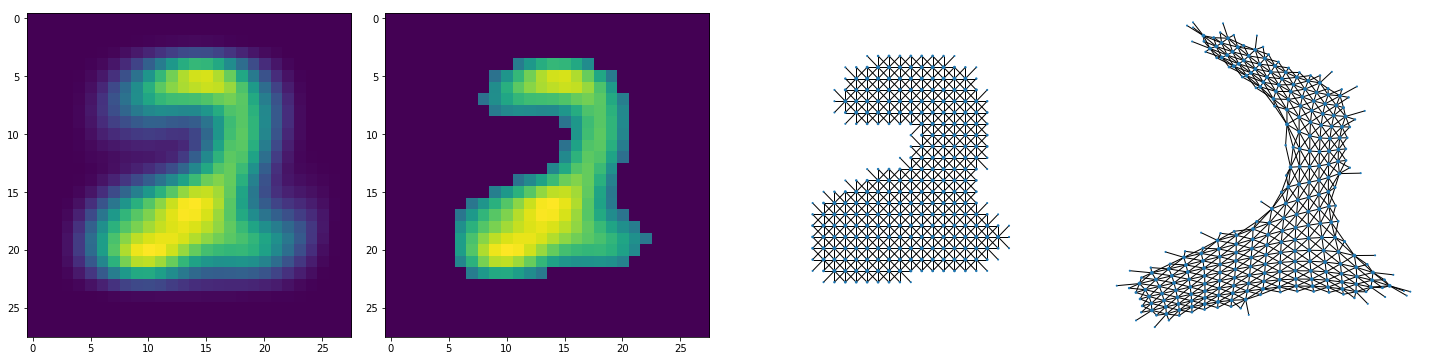

Number of nodes: 784; Number of edges: 853
Number of nodes: 784; Number of edges: 853
After removing nodes without edges:
Number of nodes: 287; Number of edges: 853


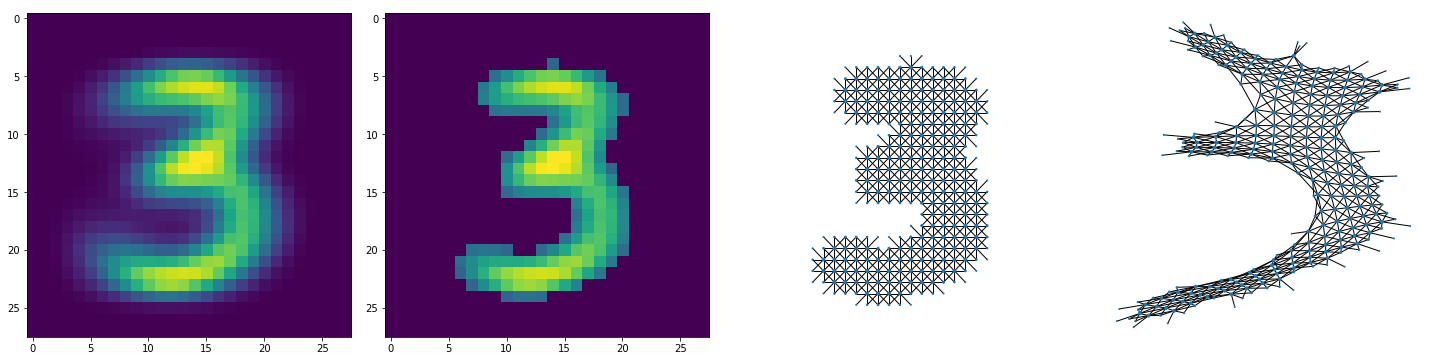

Number of nodes: 784; Number of edges: 698
Number of nodes: 784; Number of edges: 698
After removing nodes without edges:
Number of nodes: 236; Number of edges: 698


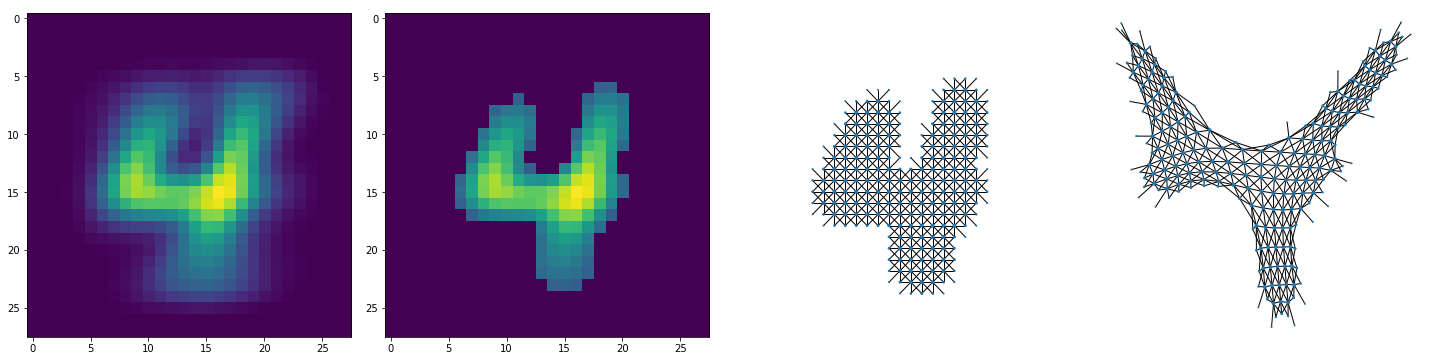

Number of nodes: 784; Number of edges: 862
Number of nodes: 784; Number of edges: 862
After removing nodes without edges:
Number of nodes: 287; Number of edges: 862


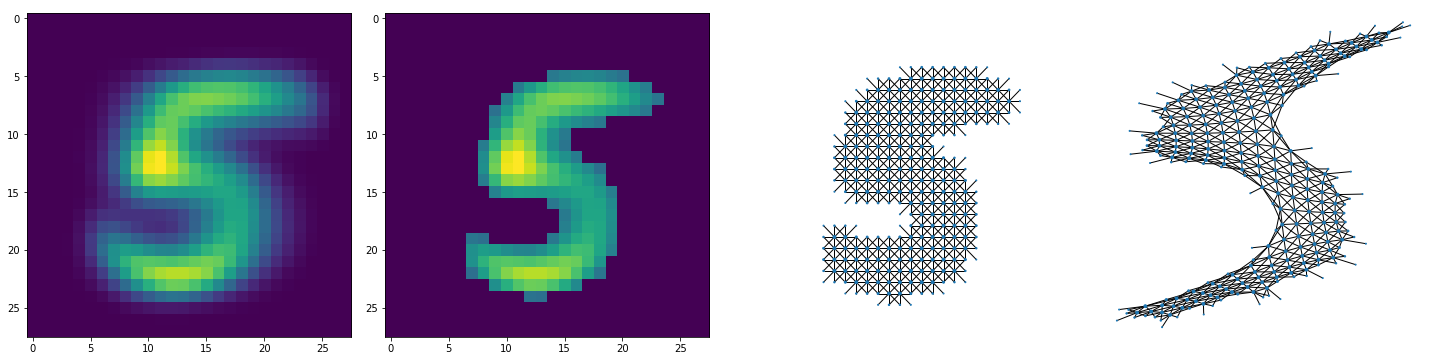

Number of nodes: 784; Number of edges: 839
Number of nodes: 784; Number of edges: 839
After removing nodes without edges:
Number of nodes: 272; Number of edges: 839


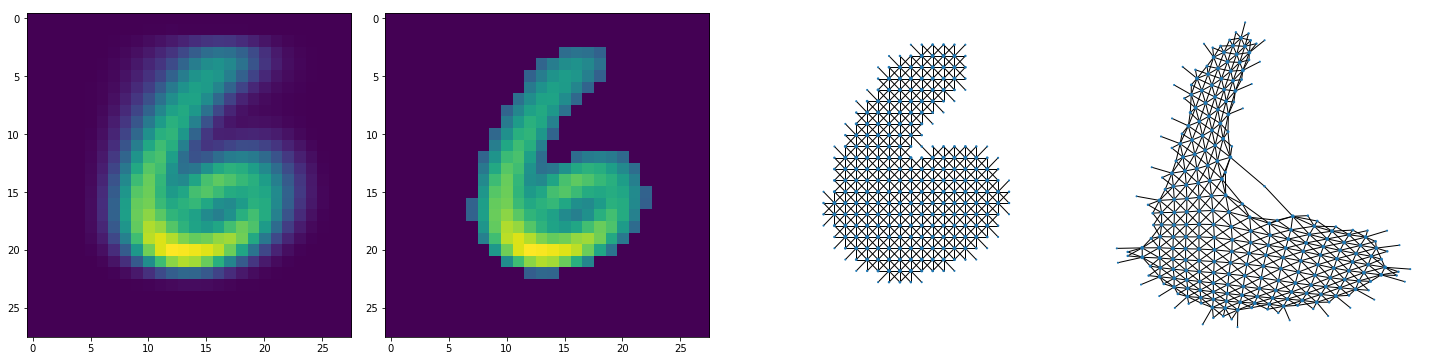

Number of nodes: 784; Number of edges: 689
Number of nodes: 784; Number of edges: 689
After removing nodes without edges:
Number of nodes: 240; Number of edges: 689


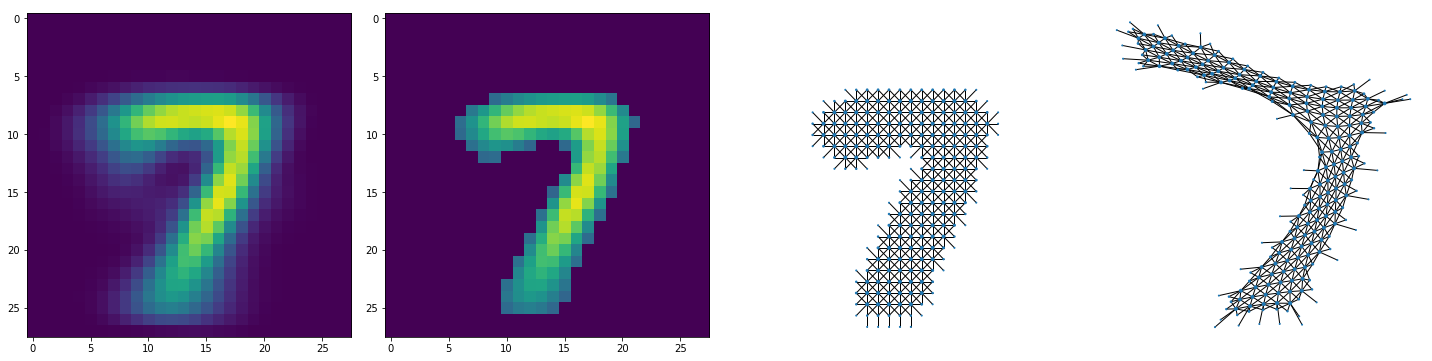

Number of nodes: 784; Number of edges: 928
Number of nodes: 784; Number of edges: 928
After removing nodes without edges:
Number of nodes: 288; Number of edges: 928


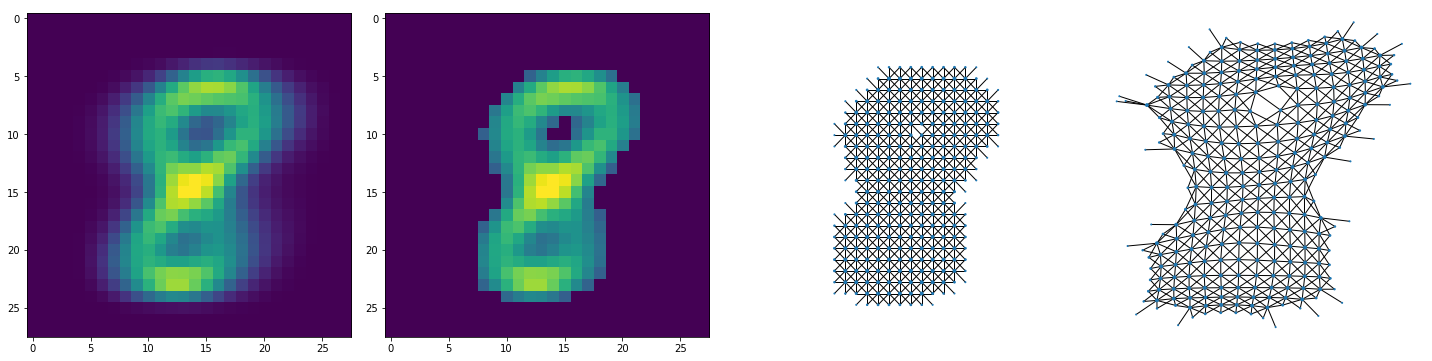

Number of nodes: 784; Number of edges: 754
Number of nodes: 784; Number of edges: 754
After removing nodes without edges:
Number of nodes: 245; Number of edges: 754


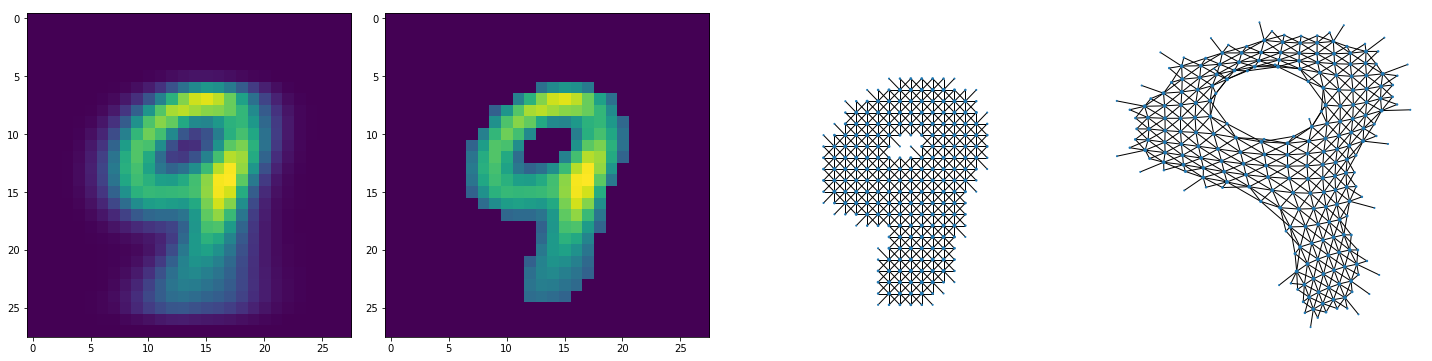

In [12]:
threshold = 0.25 # to reduce the noise for averaged signals
# threshold = 0.5
d_digit_graphs = {} # to collect feature graphs from each class

for i in range(10):
    mask = y_train == i
    
    fig, axes = plt.subplots(figsize=(20, 5), ncols=4)

    x_train_i_avg = X_train[mask].mean(axis=0).flatten()
    axes[0].imshow(x_train_i_avg.reshape(28, 28))

    # threshold the averages of pixels
    x_train_i_avg[x_train_i_avg < threshold] = 0
    axes[1].imshow(x_train_i_avg.reshape(28, 28))

    # a sparse diag matrix with the intensities values on the diagnoal
    A_diag_i = sp.diags(x_train_i_avg, dtype=np.float32).tolil()

    # "prune" the adjacency of the grid graph to preserve the subgraph with the data
    A_i = A.dot(A_diag_i)
    d_digit_graphs[i] = A_i
    
    axes[2] = draw_graph(A_i, ax=axes[2], size_factor=1)
    
    axes[3] = draw_graph(A_i, ax=axes[3], size_factor=1, spring_layout=True)
    fig.tight_layout()
    plt.show()

# Graph convolutional network for classification with different feature graphs

In [13]:
# Parameters
l2_reg = 5e-4         # Regularization rate for l2
learning_rate = 0.03  # Learning rate for SGD
batch_size = 100       # Batch size
epochs = 20         # Number of training epochs

In [14]:
from keras.layers import MaxPooling2D, Reshape
from spektral.layers import GraphConv, ChebConv
from spektral.utils import localpooling_filter

In [15]:
def GCN_single_layer(A, N=28*28, F=1,
                     n_out=10,
                     l2_reg=l2_reg, 
                     learning_rate=learning_rate,
                    ):
    # Computes a normalized Laplacian (as the conv filter)
    L = localpooling_filter(A)
    
    # Model definition
    # N: Number of nodes in the graphs
    # F: Node features dimensionality
    X_in = Input(shape=(N, F))
    # Pass A as a fixed tensor, otherwise Keras will complain about inputs of
    # different rank.
    A_in = Input(tensor=sp_matrix_to_sp_tensor(L))

    graph_conv = GraphConv(10,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_in, A_in])

    fc = Flatten()(graph_conv)
    output = Dense(n_out, activation='softmax')(fc)
    
    # Build model
    model = Model(inputs=[X_in, A_in], outputs=output)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    return model


def GCN(A, N=28*28, F=1,
        n_out=10,
        l2_reg=l2_reg, 
        learning_rate=learning_rate,
       ):
    '''Build a graph convolution network given A.
    '''
    # Computes a normalized Laplacian (as the conv filter)
    L = localpooling_filter(A)
    
    # Model definition
    # N: Number of nodes in the graphs
    # F: Node features dimensionality
    X_in = Input(shape=(N, F))
    
    # Pass A as a fixed tensor, otherwise Keras will complain about inputs of
    # different rank.
    A_in = Input(tensor=sp_matrix_to_sp_tensor(L))

    graph_conv = GraphConv(32,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_in, A_in])
    graph_conv = GraphConv(32,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([graph_conv, A_in])
    
    rs = Reshape((28, 28, 32))(graph_conv)
    pooled = MaxPooling2D(pool_size=(2, 2))(rs)
    flatten = Flatten()(pooled)
    fc = Dense(512, activation='relu')(flatten)
    output = Dense(n_out, activation='softmax')(fc)
    
    # Build model
    model = Model(inputs=[X_in, A_in], outputs=output)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    return model

In [16]:
test_scores = []

# GCN Model with full grid

In [17]:
print(A.nnz)
model_full_grid = GCN_single_layer(A)
model_full_grid.summary()

6396






Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784, 1)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (784, 784)           0                                            
__________________________________________________________________________________________________
graph_conv_1 (GraphConv)        (None, 784, 10)      20          input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 7840)         0           graph_conv_1[0][

In [18]:
# Train model
validation_data = (X_val, y_val)
model_full_grid.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    validation_data=validation_data,
                    epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 10s 199us/step - loss: 0.3826 - acc: 0.8881 - val_loss: 0.3041 - val_acc: 0.9152
Epoch 2/20
50000/50000 [==============================] - 9s 180us/step - loss: 0.3065 - acc: 0.9149 - val_loss: 0.2967 - val_acc: 0.9203
Epoch 3/20
50000/50000 [==============================] - 9s 180us/step - loss: 0.2793 - acc: 0.9222 - val_loss: 0.2778 - val_acc: 0.9233
Epoch 4/20
50000/50000 [==============================] - 9s 185us/step - loss: 0.2687 - acc: 0.9255 - val_loss: 0.3236 - val_acc: 0.9044
Epoch 5/20
50000/50000 [==============================] - 10s 193us/step - loss: 0.2587 - acc: 0.9270 - val_loss: 0.2644 - val_acc: 0.9330
Epoch 6/20
50000/50000 [==============================] - 9s 177us/step - loss: 0.2550 - acc: 0.9281 - val_loss: 0.2630 - val_acc: 0.9315
Epoch 7/20
50000/50000 [==

In [19]:
# Evaluate model
print('Evaluating model.')
eval_results = model_full_grid.evaluate(X_test,
                              y_test,
                              batch_size=batch_size)
print('Done.\n'
      'Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'GCN full grid',
    'accuracy': eval_results[1]
})

Evaluating model.
10000/10000 [==============================] - 1s 79us/step
Done.
Test loss: 0.2695222044410184
Test acc: 0.9317000031471252


# GCN model with an empty adjacency matrix

In [20]:
A0 = sp.csr_matrix(A.shape, dtype=np.float32)
print(A0.shape, A0.nnz)

model_no_graph = GCN_single_layer(A0)
model_no_graph.summary()

(784, 784) 0
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784, 1)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (784, 784)           0                                            
__________________________________________________________________________________________________
graph_conv_2 (GraphConv)        (None, 784, 10)      20          input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 7840)         0           graph_conv_2[0

In [21]:
model_no_graph.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    validation_data=validation_data,
                    epochs=epochs)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 152us/step - loss: 0.3722 - acc: 0.8930 - val_loss: 0.3130 - val_acc: 0.9085
Epoch 2/20
50000/50000 [==============================] - 7s 144us/step - loss: 0.3008 - acc: 0.9161 - val_loss: 0.2950 - val_acc: 0.9183
Epoch 3/20
50000/50000 [==============================] - 7s 143us/step - loss: 0.2966 - acc: 0.9157 - val_loss: 0.3122 - val_acc: 0.9150
Epoch 4/20
50000/50000 [==============================] - 7s 146us/step - loss: 0.2792 - acc: 0.9224 - val_loss: 0.2990 - val_acc: 0.9206
Epoch 5/20
50000/50000 [==============================] - 7s 143us/step - loss: 0.2736 - acc: 0.9236 - val_loss: 0.2887 - val_acc: 0.9243
Epoch 6/20
50000/50000 [==============================] - 7s 146us/step - loss: 0.2725 - acc: 0.9237 - val_loss: 0.3026 - val_acc: 0.9212
Epoch 7/20
50000/50000 [==============================] - 7s 147us/step - loss: 0.2685 - acc: 0.9242 - val_loss: 0.3179 - 

In [22]:
# Evaluate model
print('Evaluating model.')
eval_results = model_no_graph.evaluate(X_test,
                              y_test,
                              batch_size=batch_size)
print('Done.\n'
      'Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'GCN empty graph',
    'accuracy': eval_results[1]
})

Evaluating model.
10000/10000 [==============================] - 1s 66us/step
Done.
Test loss: 0.3236360315140337
Test acc: 0.9175000023841858


In [23]:
def fc_model(N=28*28, F=1,
                     n_out=10,
                     l2_reg=l2_reg, 
                     learning_rate=learning_rate):
    '''A fully-connected model for MNIST classification.
    '''
    X_in = Input(shape=(N, F))
    
    fc = Dense(10, activation='relu',
               kernel_regularizer=l2(l2_reg),
               use_bias=True)(Flatten()(X_in))
    
    output = Dense(n_out, activation='softmax')(fc)
    
    # Build model
    model = Model(inputs=X_in, outputs=output)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    return model
    

In [24]:
model_fc = fc_model()
model_fc.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784, 1)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_fc.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    validation_data=validation_data,
                    epochs=epochs)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 1s 17us/step - loss: 0.5626 - acc: 0.8556 - val_loss: 0.5009 - val_acc: 0.8800
Epoch 2/20
50000/50000 [==============================] - 1s 12us/step - loss: 0.4857 - acc: 0.8875 - val_loss: 0.4624 - val_acc: 0.8929
Epoch 3/20
50000/50000 [==============================] - 1s 12us/step - loss: 0.4801 - acc: 0.8893 - val_loss: 0.5113 - val_acc: 0.8727
Epoch 4/20
50000/50000 [==============================] - 1s 12us/step - loss: 0.4919 - acc: 0.8852 - val_loss: 0.4957 - val_acc: 0.8849
Epoch 5/20
50000/50000 [==============================] - 1s 13us/step - loss: 0.4793 - acc: 0.8869 - val_loss: 0.5500 - val_acc: 0.8708
Epoch 6/20
50000/50000 [==============================] - 1s 13us/step - loss: 0.4900 - acc: 0.8847 - val_loss: 0.4841 - val_acc: 0.8820
Epoch 7/20
50000/50000 [==============================] - 1s 13us/step - loss: 0.4822 - acc: 0.8879 - val_loss: 0.5741 - val_acc

In [26]:
# Evaluate model
print('Evaluating model.')
eval_results = model_fc.evaluate(X_test,
                              y_test,
                              batch_size=batch_size)
print('Done.\n'
      'Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

test_scores.append({
    'model': 'FC',
    'accuracy': eval_results[1]
})

Evaluating model.
10000/10000 [==============================] - 0s 5us/step
Done.
Test loss: 0.42481359794735907
Test acc: 0.8970000034570694


# Models with digit trimmed grid graphs

In [27]:
d_digit_models = {}
for digit in range(10):
    model_i = GCN_single_layer(d_digit_graphs[digit])
    print(digit, d_digit_graphs[digit].nnz)

    # Train model with digit feature graph
    model_i.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        validation_data=validation_data,
                        epochs=epochs)
    
    d_digit_models[digit] = model_i

0 1840
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 163us/step - loss: 0.3860 - acc: 0.8907 - val_loss: 0.3317 - val_acc: 0.9071
Epoch 2/20
50000/50000 [==============================] - 8s 151us/step - loss: 0.3132 - acc: 0.9128 - val_loss: 0.3030 - val_acc: 0.9199
Epoch 3/20
50000/50000 [==============================] - 8s 151us/step - loss: 0.2820 - acc: 0.9203 - val_loss: 0.2787 - val_acc: 0.9244
Epoch 4/20
50000/50000 [==============================] - 8s 161us/step - loss: 0.2729 - acc: 0.9237 - val_loss: 0.2873 - val_acc: 0.9269
Epoch 5/20
50000/50000 [==============================] - 8s 167us/step - loss: 0.2594 - acc: 0.9274 - val_loss: 0.2723 - val_acc: 0.9290
Epoch 6/20
50000/50000 [==============================] - 7s 146us/step - loss: 0.2444 - acc: 0.9310 - val_loss: 0.2771 - val_acc: 0.9260
Epoch 7/20
50000/50000 [==============================] - 7s 144us/step - loss: 0.2498 - acc: 0.9284 - val_loss: 0.

Epoch 19/20
50000/50000 [==============================] - 7s 144us/step - loss: 0.2067 - acc: 0.9399 - val_loss: 0.3004 - val_acc: 0.9251
Epoch 20/20
50000/50000 [==============================] - 7s 144us/step - loss: 0.1999 - acc: 0.9427 - val_loss: 0.3150 - val_acc: 0.9290
3 1456
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 151us/step - loss: 0.3957 - acc: 0.8881 - val_loss: 0.3143 - val_acc: 0.9155
Epoch 2/20
50000/50000 [==============================] - 7s 143us/step - loss: 0.3297 - acc: 0.9094 - val_loss: 0.3097 - val_acc: 0.9125
Epoch 3/20
50000/50000 [==============================] - 7s 147us/step - loss: 0.3272 - acc: 0.9091 - val_loss: 0.2980 - val_acc: 0.9231
Epoch 4/20
50000/50000 [==============================] - 7s 143us/step - loss: 0.2856 - acc: 0.9210 - val_loss: 0.3042 - val_acc: 0.9170
Epoch 5/20
50000/50000 [==============================] - 7s 147us/step - loss: 0.2654 - acc: 0.9263 - val_loss: 

Epoch 17/20
50000/50000 [==============================] - 7s 148us/step - loss: 0.2023 - acc: 0.9418 - val_loss: 0.2839 - val_acc: 0.9253
Epoch 18/20
50000/50000 [==============================] - 7s 143us/step - loss: 0.2010 - acc: 0.9412 - val_loss: 0.2976 - val_acc: 0.9216
Epoch 19/20
50000/50000 [==============================] - 7s 149us/step - loss: 0.2025 - acc: 0.9412 - val_loss: 0.2841 - val_acc: 0.9289
Epoch 20/20
50000/50000 [==============================] - 7s 148us/step - loss: 0.1965 - acc: 0.9434 - val_loss: 0.2874 - val_acc: 0.9274
6 1480
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 162us/step - loss: 0.3785 - acc: 0.8910 - val_loss: 0.3207 - val_acc: 0.9129
Epoch 2/20
50000/50000 [==============================] - 8s 151us/step - loss: 0.3065 - acc: 0.9129 - val_loss: 0.3119 - val_acc: 0.9157
Epoch 3/20
50000/50000 [==============================] - 9s 171us/step - loss: 0.2942 - acc: 0.9176 - val_loss

Epoch 15/20
50000/50000 [==============================] - 7s 148us/step - loss: 0.2129 - acc: 0.9386 - val_loss: 0.3036 - val_acc: 0.9272
Epoch 16/20
50000/50000 [==============================] - 8s 157us/step - loss: 0.2084 - acc: 0.9413 - val_loss: 0.3041 - val_acc: 0.9191
Epoch 17/20
50000/50000 [==============================] - 7s 145us/step - loss: 0.2069 - acc: 0.9406 - val_loss: 0.3306 - val_acc: 0.9145
Epoch 18/20
50000/50000 [==============================] - 7s 144us/step - loss: 0.2171 - acc: 0.9382 - val_loss: 0.3281 - val_acc: 0.9167
Epoch 19/20
50000/50000 [==============================] - 7s 149us/step - loss: 0.2044 - acc: 0.9415 - val_loss: 0.3084 - val_acc: 0.9233
Epoch 20/20
50000/50000 [==============================] - 7s 148us/step - loss: 0.2014 - acc: 0.9411 - val_loss: 0.5123 - val_acc: 0.8495
9 1304
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 155us/step - loss: 0.3714 - acc: 0.8925 - val_lo

In [28]:
for digit, model_i in d_digit_models.items():
    eval_results = model_i.evaluate(X_test,
                                  y_test,
                                  batch_size=batch_size)
    print('Digit %d' % digit)
    print('Test loss: {}\n'
          'Test acc: {}'.format(*eval_results))
    
    test_scores.append({
        'model': 'GCN trimmed grid',
        'digit': digit,
        'accuracy': eval_results[1]
    })    

10000/10000 [==============================] - 1s 65us/step
Digit 0
Test loss: 0.31108771841041744
Test acc: 0.92280000269413
10000/10000 [==============================] - 1s 64us/step
Digit 1
Test loss: 0.2912340503744781
Test acc: 0.92
10000/10000 [==============================] - 1s 64us/step
Digit 2
Test loss: 0.3211648279055953
Test acc: 0.9276000016927719
10000/10000 [==============================] - 1s 64us/step
Digit 3
Test loss: 0.3127971228957176
Test acc: 0.923099998831749
10000/10000 [==============================] - 1s 63us/step
Digit 4
Test loss: 0.3137221130821854
Test acc: 0.9182000005245209
10000/10000 [==============================] - 1s 64us/step
Digit 5
Test loss: 0.2946912558423355
Test acc: 0.9297000038623809
10000/10000 [==============================] - 1s 64us/step
Digit 6
Test loss: 0.3059236421994865
Test acc: 0.9193000036478043
10000/10000 [==============================] - 1s 64us/step
Digit 7
Test loss: 0.31608768592588604
Test acc: 0.9233000022172928

In [29]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
import pandas as pd
def plot_confusion_matrix(cm, classes=list(range(10))):
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(cm_df, 
                     fmt='.3f',
                     annot=True, cmap='Reds', ax=ax)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    fig.tight_layout()
    return fig

(10000, 10)


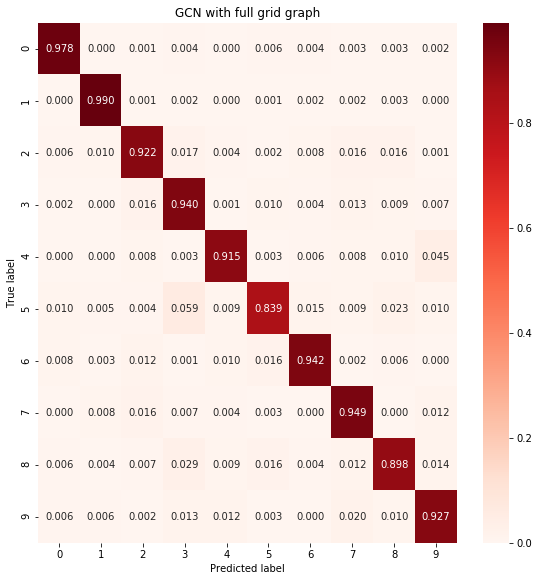

In [31]:
y_test_preds = model_full_grid.predict(X_test)
print(y_test_preds.shape)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
fig = plot_confusion_matrix(cm/cm.sum(axis=1))
fig.get_axes()[0].set_title('GCN with full grid graph');
fig.savefig('img/CM_GCN_full_grid.pdf')

(10000, 10)


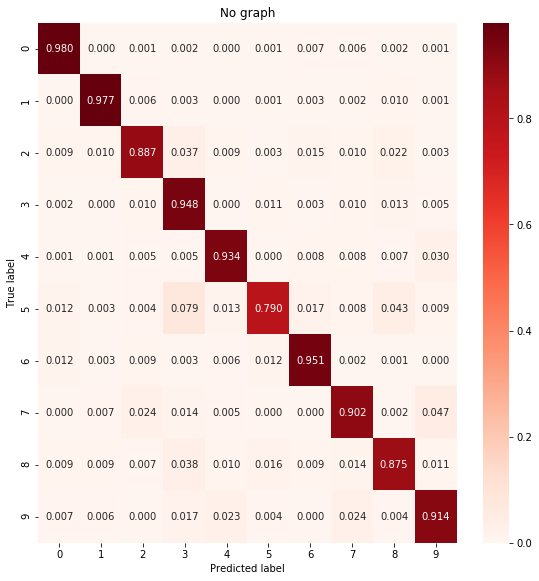

In [32]:
y_test_preds = model_no_graph.predict(X_test)
print(y_test_preds.shape)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
fig = plot_confusion_matrix(cm/cm.sum(axis=1))
fig.get_axes()[0].set_title('No graph');

In [33]:
# compute per-class accuracy for the 10 models
acc_df = {}

for model_name, model in d_digit_models.items():
    
    y_test_preds = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
    
#     y_train_preds = model.predict(X_train)
#     cm = metrics.confusion_matrix(y_train, np.argmax(y_train_preds, axis=1))
    
    acc_per_classes = np.diag(cm/cm.sum(axis=1))
#     acc_per_classes = np.diag(cm)
    
    acc_df[model_name] = acc_per_classes

In [34]:
acc_df = pd.DataFrame.from_dict(acc_df)
acc_df

0         1         2         3         4         5         6  \
0  0.967347  0.971429  0.967347  0.954082  0.974490  0.975510  0.979592   
1  0.990308  0.985903  0.982379  0.992070  0.977974  0.990308  0.982379   
2  0.934109  0.881783  0.938953  0.907946  0.843023  0.894380  0.935078   
3  0.868317  0.902970  0.911881  0.933663  0.942574  0.912871  0.913861   
4  0.893075  0.936864  0.936864  0.916497  0.954175  0.931772  0.897149   
5  0.895740  0.880045  0.877803  0.855381  0.873318  0.872197  0.863229   
6  0.938413  0.953027  0.951983  0.944676  0.951983  0.958246  0.937370   
7  0.914397  0.940661  0.928016  0.922179  0.908560  0.931907  0.905642   
8  0.883984  0.844969  0.870637  0.872690  0.887064  0.913758  0.819302   
9  0.930624  0.890981  0.897919  0.915758  0.861249  0.904856  0.943508   

          7         8         9  
0  0.962245  0.907143  0.963265  
1  0.973568  0.993833  0.988546  
2  0.857558  0.890504  0.905039  
3  0.940594  0.818812  0.905941  
4  0.925662  0.816701  0.937882  
5  0.859865  0.876682  0.887892  
6  0.957203  0.881002  0.934238  
7  0.911479  0.929961  0.918288  
8  0.928131  0.551335  0.830595  
9  0.907830  0.855302  0.903865

In [35]:
y_test_preds = model_full_grid.predict(X_test)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))

# y_train_preds = model_full_grid.predict(X_train)
# cm = metrics.confusion_matrix(y_train, np.argmax(y_train_preds, axis=1))


acc_per_class_full_model = np.diag(cm/cm.sum(axis=1))
# acc_per_class_full_model = np.diag(cm)
acc_per_class_full_model

array([0.97755102, 0.99030837, 0.92151163, 0.93960396, 0.91547862,
       0.83856502, 0.94154489, 0.94941634, 0.89835729, 0.92666006])

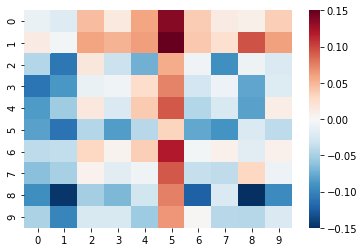

In [36]:
# accuracy gain compared to full model
sns.heatmap(acc_df - acc_per_class_full_model,
            cmap='RdBu_r',
            vmin=-0.15,
            vmax=0.15
           )

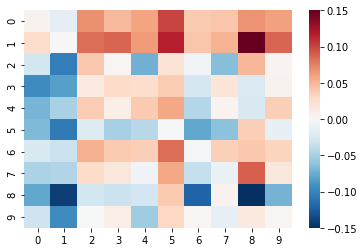

In [37]:
# accuracy gain compared to 10 averaged models
sns.heatmap(acc_df - acc_df.mean(axis=1),
            cmap='RdBu_r',
            vmin=-0.15,
            vmax=0.15
           )

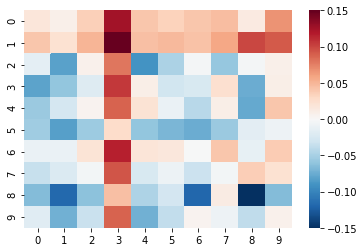

In [38]:
y_test_preds = model_no_graph.predict(X_test)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))


acc_per_class_no_graph = np.diag(cm/cm.sum(axis=0))

# accuracy gain compared to no graph model
sns.heatmap(acc_df - acc_per_class_no_graph,
            cmap='RdBu_r',
            vmin=-0.15,
            vmax=0.15
           )

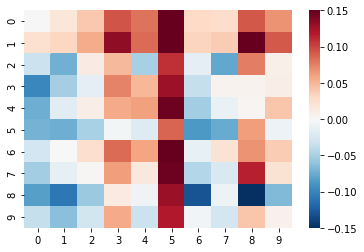

In [39]:
y_test_preds = model_fc.predict(X_test)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))


acc_per_class_fc = np.diag(cm/cm.sum(axis=0))

# accuracy gain compared to FC model
sns.heatmap(acc_df - acc_per_class_fc,
            cmap='RdBu_r',
            vmin=-0.15,
            vmax=0.15
           )

# Models with digit feature graph as conv filter

In [40]:
!mkdir -p img

Number of nodes: 784; Number of edges: 2430
Number of nodes: 784; Number of edges: 2430
After removing nodes without edges:
Number of nodes: 464; Number of edges: 2430


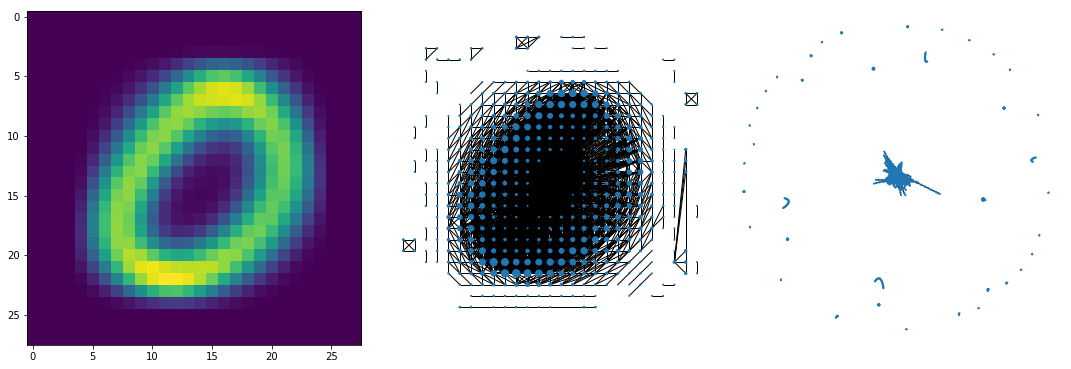

Number of nodes: 784; Number of edges: 1389
Number of nodes: 784; Number of edges: 1389
After removing nodes without edges:
Number of nodes: 401; Number of edges: 1389


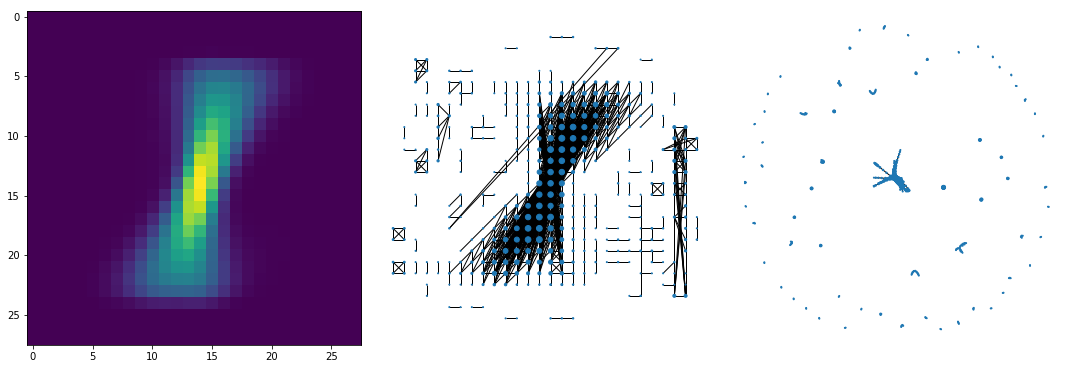

Number of nodes: 784; Number of edges: 1059
Number of nodes: 784; Number of edges: 1059
After removing nodes without edges:
Number of nodes: 465; Number of edges: 1059


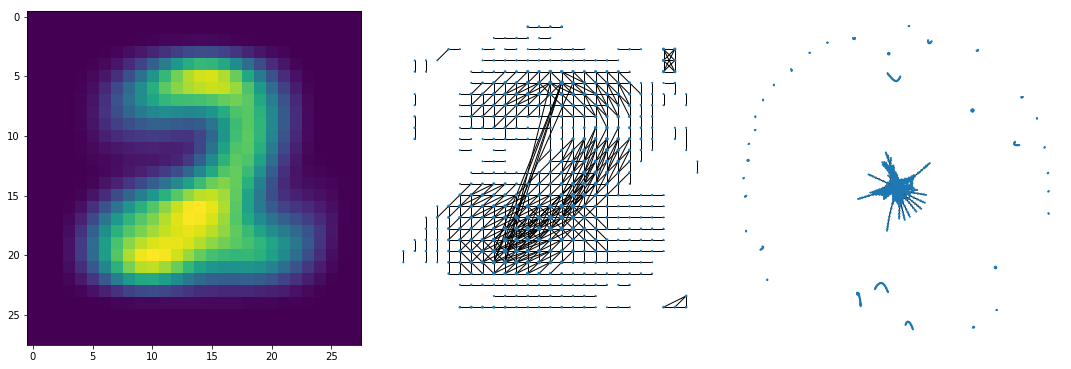

Number of nodes: 784; Number of edges: 1258
Number of nodes: 784; Number of edges: 1258
After removing nodes without edges:
Number of nodes: 438; Number of edges: 1258


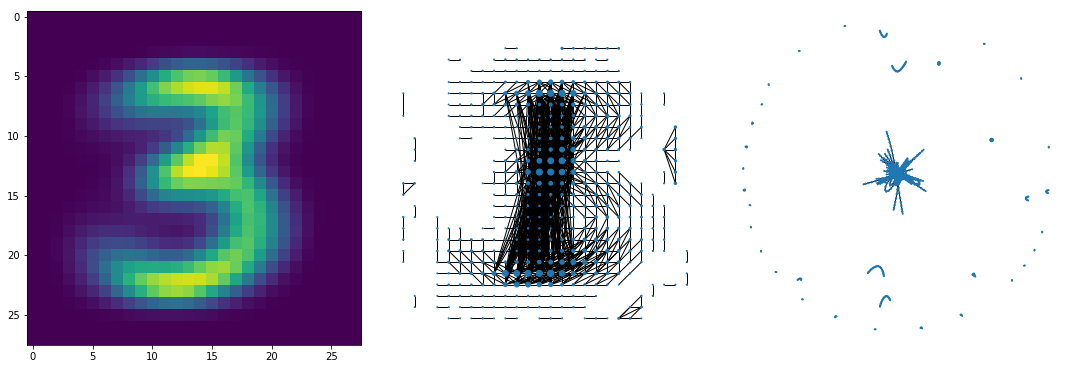

Number of nodes: 784; Number of edges: 1057
Number of nodes: 784; Number of edges: 1057
After removing nodes without edges:
Number of nodes: 398; Number of edges: 1057


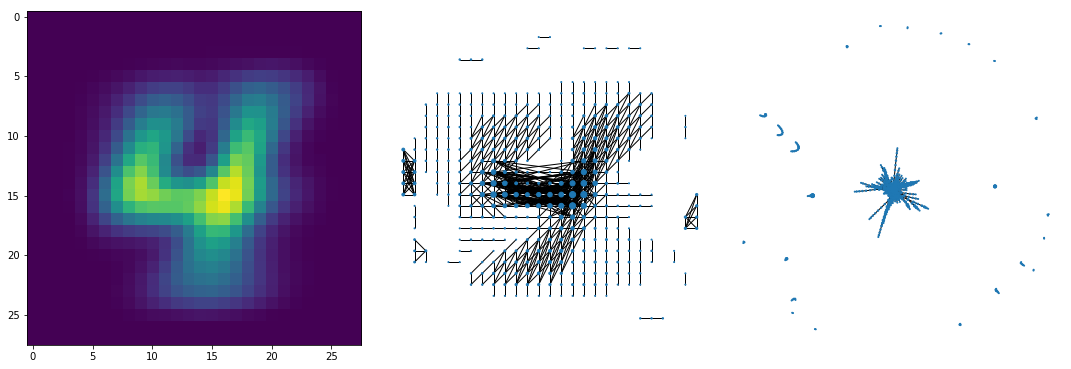

Number of nodes: 784; Number of edges: 919
Number of nodes: 784; Number of edges: 919
After removing nodes without edges:
Number of nodes: 474; Number of edges: 919


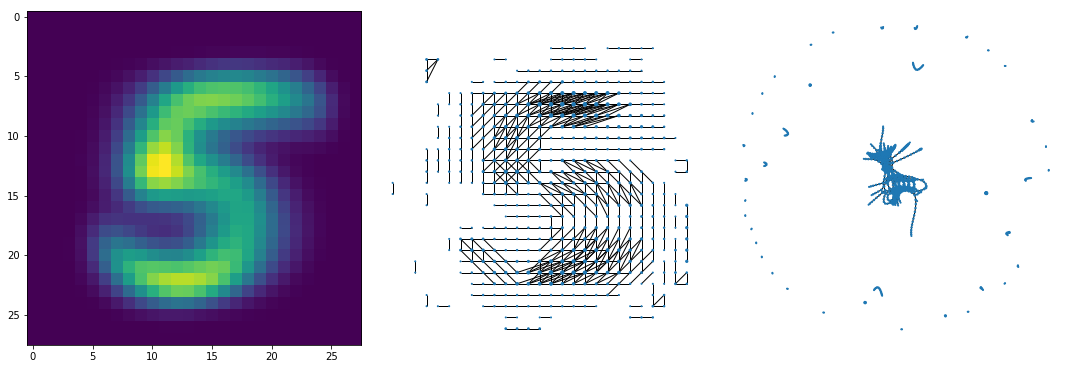

Number of nodes: 784; Number of edges: 1447
Number of nodes: 784; Number of edges: 1447
After removing nodes without edges:
Number of nodes: 453; Number of edges: 1447


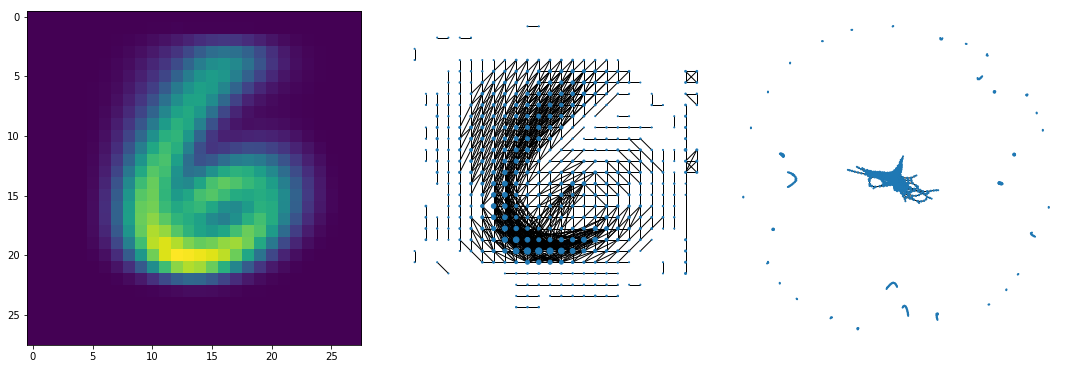

Number of nodes: 784; Number of edges: 1295
Number of nodes: 784; Number of edges: 1295
After removing nodes without edges:
Number of nodes: 394; Number of edges: 1295


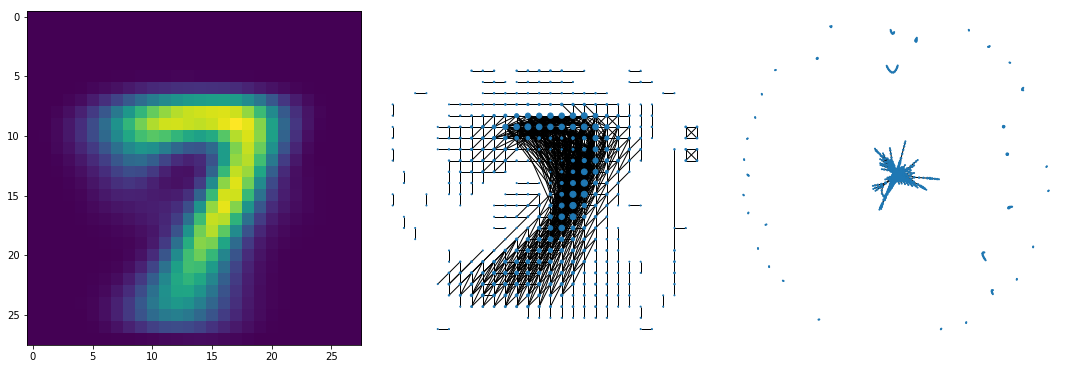

Number of nodes: 784; Number of edges: 1240
Number of nodes: 784; Number of edges: 1240
After removing nodes without edges:
Number of nodes: 446; Number of edges: 1240


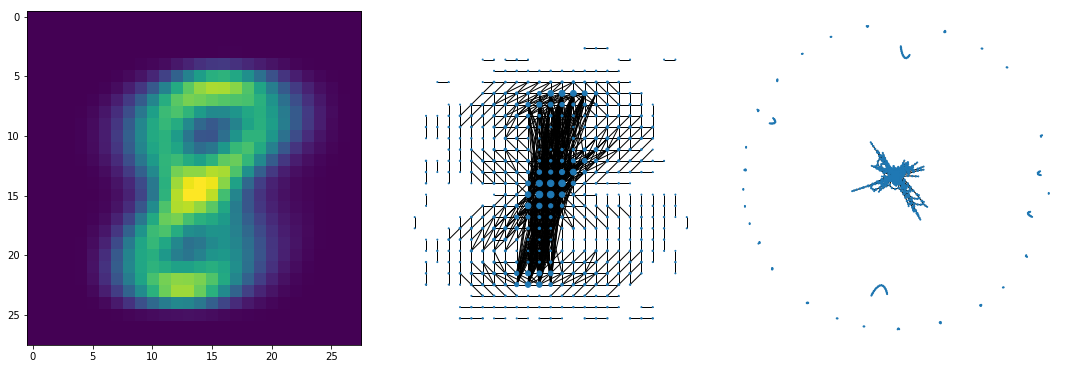

Number of nodes: 784; Number of edges: 1258
Number of nodes: 784; Number of edges: 1258
After removing nodes without edges:
Number of nodes: 458; Number of edges: 1258


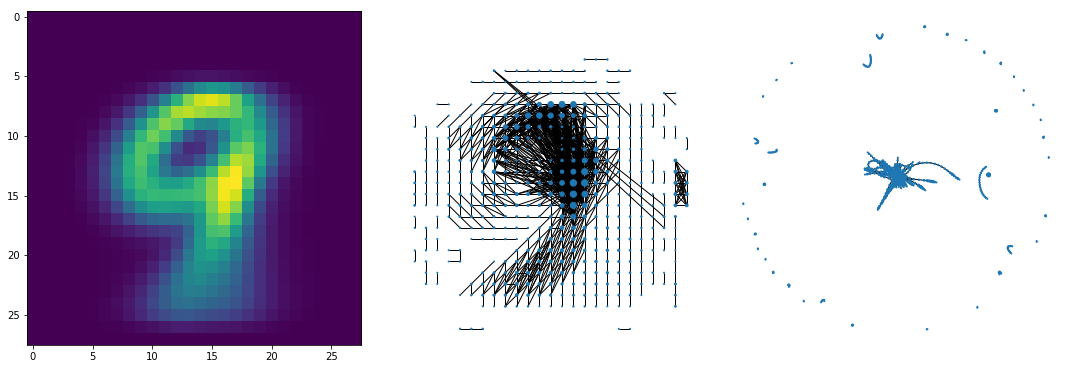

In [41]:
d_digit_corr_graphs = {} # build digit feature graph by correlation

# this way of constructing feature graphs enable 
# the GCN to not only see pixels locally, but also globally based on known patterns

for i in range(10):
    mask = y_train == i
    
    dist = metrics.pairwise_distances(X_train[mask].reshape(-1, 784).T, metric='cosine', n_jobs=-2)
    
    W = sp.coo_matrix(1 - dist, dtype=np.float32)

    # No self-connections.
    W.setdiag(0)

    # Non-directed graph.
    bigger = W.T > W
    W = W - W.multiply(bigger) + W.T.multiply(bigger)

    assert W.nnz % 2 == 0
    assert np.abs(W - W.T).mean() < 1e-10
    assert type(W) is sp.csr.csr_matrix    
    
    
    fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

    x_train_i_avg = X_train[mask].mean(axis=0).flatten()
    axes[0].imshow(x_train_i_avg.reshape(28, 28))

    # thresholding 
    W = W.multiply(W > 0.8)

    d_digit_corr_graphs[i] = W
    
    axes[1] = draw_graph(W, ax=axes[1], size_factor=1)
    
    axes[2] = draw_graph(W, ax=axes[2], size_factor=1, spring_layout=True)
    fig.tight_layout()
    plt.show()

Number of nodes: 784; Number of edges: 1055
Number of nodes: 784; Number of edges: 2430
Number of nodes: 784; Number of edges: 462
Number of nodes: 784; Number of edges: 1389
Number of nodes: 784; Number of edges: 920
Number of nodes: 784; Number of edges: 1059
Number of nodes: 784; Number of edges: 853
Number of nodes: 784; Number of edges: 1258
Number of nodes: 784; Number of edges: 698
Number of nodes: 784; Number of edges: 1057
Number of nodes: 784; Number of edges: 862
Number of nodes: 784; Number of edges: 919
Number of nodes: 784; Number of edges: 839
Number of nodes: 784; Number of edges: 1447
Number of nodes: 784; Number of edges: 689
Number of nodes: 784; Number of edges: 1295
Number of nodes: 784; Number of edges: 928
Number of nodes: 784; Number of edges: 1240
Number of nodes: 784; Number of edges: 754
Number of nodes: 784; Number of edges: 1258


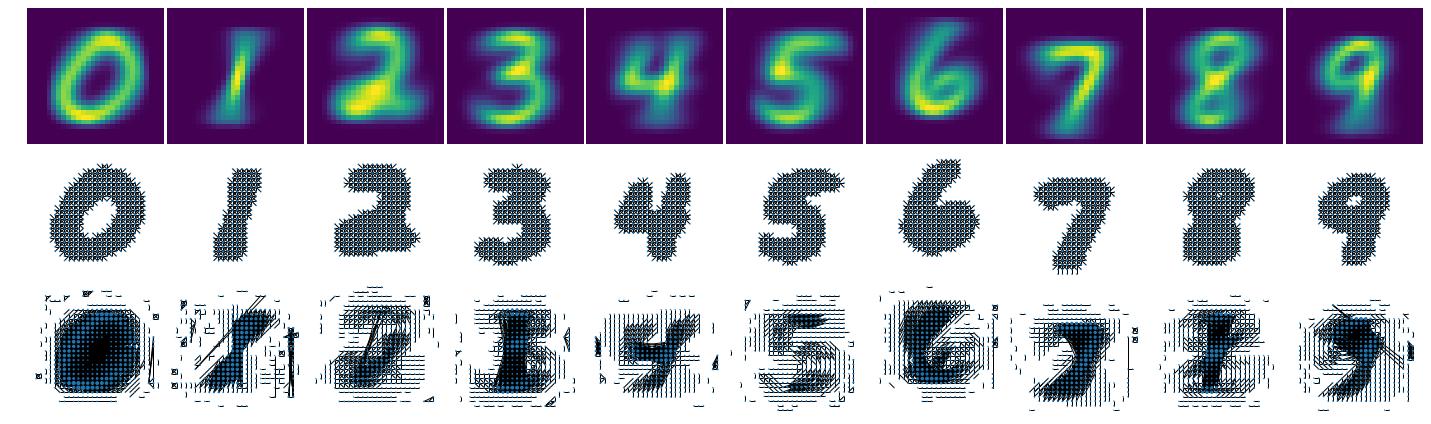

In [42]:
# draw averaged digits and the two graphs for each class
fig, axes = plt.subplots(figsize=(20, 6), nrows=3, ncols=10)

for i in range(10):
    mask = y_train == i
    x_train_i_avg = X_train[mask].mean(axis=0).flatten()
    axes[0, i].imshow(x_train_i_avg.reshape(28, 28))
    axes[0, i].axis('off')
    
    axes[1, i] = draw_graph(d_digit_graphs[i], ax=axes[1, i], size_factor=0.2)
    axes[2, i] = draw_graph(d_digit_corr_graphs[i], ax=axes[2, i], size_factor=0.2)
    
    
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

fig.savefig('img/MNIST_graphs.pdf')

In [43]:
d_digit_models_corr = {}
for digit in range(10):
    model_i = GCN_single_layer(d_digit_corr_graphs[digit])
    print(digit, d_digit_corr_graphs[digit].nnz)

    # Train model with digit feature graph
    model_i.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        validation_data=validation_data,
                        epochs=epochs)
    
    d_digit_models_corr[digit] = model_i

0 4860
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 177us/step - loss: 0.4060 - acc: 0.8824 - val_loss: 0.3037 - val_acc: 0.9126
Epoch 2/20
50000/50000 [==============================] - 8s 165us/step - loss: 0.2852 - acc: 0.9177 - val_loss: 0.2663 - val_acc: 0.9234
Epoch 3/20
50000/50000 [==============================] - 8s 161us/step - loss: 0.2642 - acc: 0.9238 - val_loss: 0.2618 - val_acc: 0.9257
Epoch 4/20
50000/50000 [==============================] - 8s 161us/step - loss: 0.2393 - acc: 0.9304 - val_loss: 0.2540 - val_acc: 0.9297
Epoch 5/20
50000/50000 [==============================] - 8s 167us/step - loss: 0.2394 - acc: 0.9309 - val_loss: 0.2523 - val_acc: 0.9317
Epoch 6/20
50000/50000 [==============================] - 8s 161us/step - loss: 0.2314 - acc: 0.9335 - val_loss: 0.2295 - val_acc: 0.9371
Epoch 7/20
50000/50000 [==============================] - 8s 166us/step - loss: 0.2124 - acc: 0.9386 - val_loss: 0.

Epoch 19/20
50000/50000 [==============================] - 8s 151us/step - loss: 0.1832 - acc: 0.9461 - val_loss: 0.2518 - val_acc: 0.9283
Epoch 20/20
50000/50000 [==============================] - 8s 155us/step - loss: 0.1812 - acc: 0.9469 - val_loss: 0.2519 - val_acc: 0.9291
3 2516
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 182us/step - loss: 0.3919 - acc: 0.8868 - val_loss: 0.3199 - val_acc: 0.9140
Epoch 2/20
50000/50000 [==============================] - 8s 159us/step - loss: 0.3153 - acc: 0.9107 - val_loss: 0.3084 - val_acc: 0.9144
Epoch 3/20
50000/50000 [==============================] - 8s 157us/step - loss: 0.2739 - acc: 0.9235 - val_loss: 0.2748 - val_acc: 0.9240
Epoch 4/20
50000/50000 [==============================] - 8s 157us/step - loss: 0.2476 - acc: 0.9303 - val_loss: 0.2550 - val_acc: 0.9324
Epoch 5/20
50000/50000 [==============================] - 8s 156us/step - loss: 0.2363 - acc: 0.9321 - val_loss: 

Epoch 17/20
50000/50000 [==============================] - 8s 155us/step - loss: 0.1688 - acc: 0.9498 - val_loss: 0.2966 - val_acc: 0.9279
Epoch 18/20
50000/50000 [==============================] - 8s 155us/step - loss: 0.1736 - acc: 0.9492 - val_loss: 0.2519 - val_acc: 0.9323
Epoch 19/20
50000/50000 [==============================] - 8s 156us/step - loss: 0.1743 - acc: 0.9495 - val_loss: 0.3310 - val_acc: 0.9203
Epoch 20/20
50000/50000 [==============================] - 8s 156us/step - loss: 0.1732 - acc: 0.9488 - val_loss: 0.2561 - val_acc: 0.9391
6 2894
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 177us/step - loss: 0.4078 - acc: 0.8799 - val_loss: 0.3519 - val_acc: 0.9035
Epoch 2/20
50000/50000 [==============================] - 8s 162us/step - loss: 0.3310 - acc: 0.9040 - val_loss: 0.3235 - val_acc: 0.9063
Epoch 3/20
50000/50000 [==============================] - 8s 162us/step - loss: 0.3158 - acc: 0.9102 - val_loss

Epoch 15/20
50000/50000 [==============================] - 8s 150us/step - loss: 0.1896 - acc: 0.9453 - val_loss: 0.2421 - val_acc: 0.9330
Epoch 16/20
50000/50000 [==============================] - 8s 150us/step - loss: 0.1802 - acc: 0.9476 - val_loss: 0.2281 - val_acc: 0.9390
Epoch 17/20
50000/50000 [==============================] - 8s 151us/step - loss: 0.1769 - acc: 0.9484 - val_loss: 0.2492 - val_acc: 0.9369
Epoch 18/20
50000/50000 [==============================] - 8s 150us/step - loss: 0.1789 - acc: 0.9472 - val_loss: 0.2662 - val_acc: 0.9342
Epoch 19/20
50000/50000 [==============================] - 8s 150us/step - loss: 0.1839 - acc: 0.9460 - val_loss: 0.2616 - val_acc: 0.9371
Epoch 20/20
50000/50000 [==============================] - 8s 150us/step - loss: 0.1817 - acc: 0.9472 - val_loss: 0.2643 - val_acc: 0.9300
9 2516
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 170us/step - loss: 0.3721 - acc: 0.8924 - val_lo

In [44]:
d_digit_models_corr[0].summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 784, 1)       0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (784, 784)           0                                            
__________________________________________________________________________________________________
graph_conv_13 (GraphConv)       (None, 784, 10)      20          input_26[0][0]                   
                                                                 input_27[0][0]                   
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 7840)         0           graph_conv_13[0][0]       

In [45]:
for digit, model_i in d_digit_models_corr.items():
    eval_results = model_i.evaluate(X_test,
                                  y_test,
                                  batch_size=batch_size)
    print('Digit %d' % digit)
    print('Test loss: {}\n'
          'Test acc: {}'.format(*eval_results))
    
    test_scores.append({
        'model': 'GCN correlation graph',
        'digit': digit,
        'accuracy': eval_results[1]
    })        

10000/10000 [==============================] - 1s 72us/step
Digit 0
Test loss: 0.24031424325192347
Test acc: 0.9390000057220459
10000/10000 [==============================] - 1s 70us/step
Digit 1
Test loss: 0.27213858811650427
Test acc: 0.9314000004529953
10000/10000 [==============================] - 1s 68us/step
Digit 2
Test loss: 0.2436372311739251
Test acc: 0.9364000028371811
10000/10000 [==============================] - 1s 68us/step
Digit 3
Test loss: 0.2606982318405062
Test acc: 0.9364000016450882
10000/10000 [==============================] - 1s 68us/step
Digit 4
Test loss: 0.2769152326043695
Test acc: 0.9329000014066696
10000/10000 [==============================] - 1s 68us/step
Digit 5
Test loss: 0.2536799171566963
Test acc: 0.9413000047206879
10000/10000 [==============================] - 1s 69us/step
Digit 6
Test loss: 0.22794081869069488
Test acc: 0.9404000025987626
10000/10000 [==============================] - 1s 69us/step
Digit 7
Test loss: 0.3043769664689899
Test acc: 

In [46]:
test_scores

[{'model': 'GCN full grid', 'accuracy': 0.9317000031471252},
 {'model': 'GCN empty graph', 'accuracy': 0.9175000023841858},
 {'model': 'FC', 'accuracy': 0.8970000034570694},
 {'model': 'GCN trimmed grid', 'digit': 0, 'accuracy': 0.92280000269413},
 {'model': 'GCN trimmed grid', 'digit': 1, 'accuracy': 0.92},
 {'model': 'GCN trimmed grid', 'digit': 2, 'accuracy': 0.9276000016927719},
 {'model': 'GCN trimmed grid', 'digit': 3, 'accuracy': 0.923099998831749},
 {'model': 'GCN trimmed grid', 'digit': 4, 'accuracy': 0.9182000005245209},
 {'model': 'GCN trimmed grid', 'digit': 5, 'accuracy': 0.9297000038623809},
 {'model': 'GCN trimmed grid', 'digit': 6, 'accuracy': 0.9193000036478043},
 {'model': 'GCN trimmed grid', 'digit': 7, 'accuracy': 0.9233000022172928},
 {'model': 'GCN trimmed grid', 'digit': 8, 'accuracy': 0.854699998497963},
 {'model': 'GCN trimmed grid', 'digit': 9, 'accuracy': 0.9188000035285949},
 {'model': 'GCN correlation graph',
  'digit': 0,
  'accuracy': 0.9390000057220459},

In [47]:
import pickle
pickle.dump(test_scores, open('models/test_scores.pkl', 'wb'))

In [48]:
test_scores_df = pd.DataFrame(test_scores)
test_scores_df

model  accuracy  digit
0           GCN full grid    0.9317    NaN
1         GCN empty graph    0.9175    NaN
2                      FC    0.8970    NaN
3        GCN trimmed grid    0.9228    0.0
4        GCN trimmed grid    0.9200    1.0
5        GCN trimmed grid    0.9276    2.0
6        GCN trimmed grid    0.9231    3.0
7        GCN trimmed grid    0.9182    4.0
8        GCN trimmed grid    0.9297    5.0
9        GCN trimmed grid    0.9193    6.0
10       GCN trimmed grid    0.9233    7.0
11       GCN trimmed grid    0.8547    8.0
12       GCN trimmed grid    0.9188    9.0
13  GCN correlation graph    0.9390    0.0
14  GCN correlation graph    0.9314    1.0
15  GCN correlation graph    0.9364    2.0
16  GCN correlation graph    0.9364    3.0
17  GCN correlation graph    0.9329    4.0
18  GCN correlation graph    0.9413    5.0
19  GCN correlation graph    0.9404    6.0
20  GCN correlation graph    0.9260    7.0
21  GCN correlation graph    0.9331    8.0
22  GCN correlation graph    0.9368    9.0

In [49]:
test_scores_df_digits = test_scores_df.dropna()
test_scores_df_digits['digit'] = test_scores_df_digits['digit'].astype(np.int)
test_scores_df_digits = test_scores_df_digits.pivot(index='model', columns='digit', values='accuracy')
test_scores_df_digits.loc[['GCN trimmed grid', 'GCN correlation graph']]

/Users/zichen/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


digit                       0       1       2       3       4       5       6  \
model                                                                           
GCN trimmed grid       0.9228  0.9200  0.9276  0.9231  0.9182  0.9297  0.9193   
GCN correlation graph  0.9390  0.9314  0.9364  0.9364  0.9329  0.9413  0.9404   

digit                       7       8       9  
model                                          
GCN trimmed grid       0.9233  0.8547  0.9188  
GCN correlation graph  0.9260  0.9331  0.9368

In [50]:
test_scores_df_digits.loc[['GCN trimmed grid', 'GCN correlation graph']].mean(axis=1)

model
GCN trimmed grid         0.91575
GCN correlation graph    0.93537
dtype: float64

In [51]:
test_scores_df.loc[test_scores_df['digit'].isnull()].set_index('model')[['accuracy']]

accuracy
model                    
GCN full grid      0.9317
GCN empty graph    0.9175
FC                 0.8970

In [52]:
# compute per-class accuracy for the 10 models
acc_df_corr = {}

for model_name, model in d_digit_models_corr.items():
    
    y_test_preds = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))
    
#     y_train_preds = model.predict(X_train)
#     cm = metrics.confusion_matrix(y_train, np.argmax(y_train_preds, axis=1))
    
    acc_per_classes = np.diag(cm/cm.sum(axis=1))
#     acc_per_classes = np.diag(cm)
    
    acc_df_corr[model_name] = acc_per_classes
    
acc_df_corr = pd.DataFrame.from_dict(acc_df)
acc_df_corr

0         1         2         3         4         5         6  \
0  0.967347  0.971429  0.967347  0.954082  0.974490  0.975510  0.979592   
1  0.990308  0.985903  0.982379  0.992070  0.977974  0.990308  0.982379   
2  0.934109  0.881783  0.938953  0.907946  0.843023  0.894380  0.935078   
3  0.868317  0.902970  0.911881  0.933663  0.942574  0.912871  0.913861   
4  0.893075  0.936864  0.936864  0.916497  0.954175  0.931772  0.897149   
5  0.895740  0.880045  0.877803  0.855381  0.873318  0.872197  0.863229   
6  0.938413  0.953027  0.951983  0.944676  0.951983  0.958246  0.937370   
7  0.914397  0.940661  0.928016  0.922179  0.908560  0.931907  0.905642   
8  0.883984  0.844969  0.870637  0.872690  0.887064  0.913758  0.819302   
9  0.930624  0.890981  0.897919  0.915758  0.861249  0.904856  0.943508   

          7         8         9  
0  0.962245  0.907143  0.963265  
1  0.973568  0.993833  0.988546  
2  0.857558  0.890504  0.905039  
3  0.940594  0.818812  0.905941  
4  0.925662  0.816701  0.937882  
5  0.859865  0.876682  0.887892  
6  0.957203  0.881002  0.934238  
7  0.911479  0.929961  0.918288  
8  0.928131  0.551335  0.830595  
9  0.907830  0.855302  0.903865

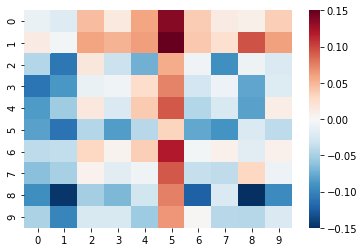

In [53]:
# accuracy gain compared to full model
sns.heatmap(acc_df_corr - acc_per_class_full_model,
            cmap='RdBu_r',
            vmin=-0.15,
            vmax=0.15
           )

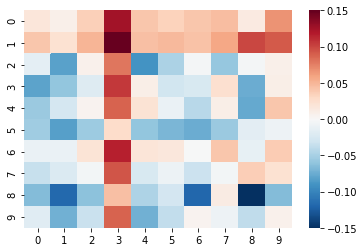

In [54]:
y_test_preds = model_no_graph.predict(X_test)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))


acc_per_class_no_graph = np.diag(cm/cm.sum(axis=0))

# accuracy gain compared to no graph model
sns.heatmap(acc_df_corr - acc_per_class_no_graph,
            cmap='RdBu_r',
            vmin=-0.15,
            vmax=0.15
           )

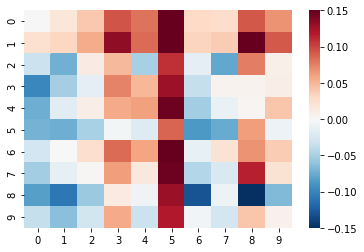

In [55]:
y_test_preds = model_fc.predict(X_test)
cm = metrics.confusion_matrix(y_test, np.argmax(y_test_preds, axis=1))


acc_per_class_fc = np.diag(cm/cm.sum(axis=0))

# accuracy gain compared to FC model
sns.heatmap(acc_df_corr - acc_per_class_fc,
            cmap='RdBu_r',
            vmin=-0.15,
            vmax=0.15
           )